In [1]:
from utils.transforms import get_transform
from datasets.H2gigaDataset import H2gigaDataset
import torch
from models.BranchedERFNet import BranchedHyperNet
from criterions.my_loss import SpatialEmbLoss
from utils.utils import AverageMeter

dir = '../Data/augmented/H2giga'

In [2]:
transfrom= get_transform([
                {
                    'name': 'ToTensor',
                    'opts': {
                        'keys': ('image', 'hs','instance', 'label'),
                        'type': (torch.FloatTensor,torch.FloatTensor, torch.ByteTensor, torch.ByteTensor),
                    }
                }
    ])
data = H2gigaDataset(dir,type='train')


In [3]:
sample = data.__getitem__(500)

image = sample['image']
ins = sample['instance']
clmap = sample['label']

print(type(image),image.shape)
print(type(ins),ins.shape)
print(sample.keys())

<class 'numpy.ndarray'> (416, 416, 3)
<class 'numpy.ndarray'> (416, 416)
dict_keys(['image', 'im_name', 'hs', 'instance', 'label'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(416, 416, 164)


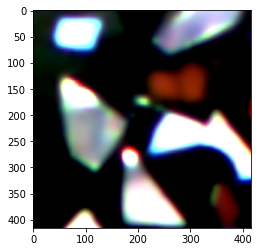

In [4]:
import matplotlib.pyplot as plt
hs = sample['hs']
plt.imshow(hs[...,(160,100,45)])

print(hs.shape)

(416, 416)


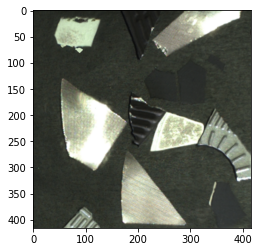

In [5]:
plt.imshow(image)
print(clmap.shape)

In [151]:

h, w, c = image.shape
crop_size = w // 2, h // 2
crops=[]
for j in range(2):
    x_start = 150
    x_end = 566
        
    y_start = j * crop_size[1]+96
    y_end = np.clip((j + 1) * crop_size[1],0,w)
    image_crop = image[y_start:y_end, x_start:x_end, ...]
    gt_crop = clmap[y_start:y_end, x_start:x_end, ...]
    crops.append((image_crop, gt_crop))

(416, 416, 3)


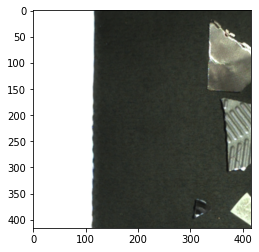

In [154]:
print(crops[0][0].shape)
plt.imshow(crops[0][0])

In [1]:
import os
from glob import glob
from skimage import io
import numpy as np

data_dir = '../Data/H2giga/'
project_name = 'train'
image_dir = os.path.join(data_dir, project_name, 'images')
instance_dir = os.path.join(data_dir, project_name,'instances')
classmap_dir = os.path.join(data_dir, project_name,'classmaps')
hs_dir = os.path.join(data_dir, project_name,'hs')
image_names = sorted(glob(os.path.join(image_dir, '*.png'))) 
instance_names = sorted(glob(os.path.join(instance_dir, '*.png')))
classmap_names = sorted(glob(os.path.join(classmap_dir, '*.png')))
hs_names = sorted(glob(os.path.join(hs_dir, '*.npy')))

In [2]:
crops_dir = '../Data/augmented/H2giga'
data_subset = 'train'
image_path = os.path.join(crops_dir, data_subset, 'images/')
classmap_path = os.path.join(crops_dir, data_subset, 'classmaps/')
instance_path = os.path.join(crops_dir, data_subset, 'instances/')
hs_path = os.path.join(crops_dir, data_subset, 'hs/')

In [3]:
print(hs_path+os.path.basename(hs_names[0])[:-4] + "_{:02d}".format(1))
print(len(image_names))


../Data/augmented/H2giga/train/hs/20220719_H2GIGA_000_002_snapshot_REF_01
21


In [4]:
for id in range(len(image_names)):
    image = io.imread(image_names[id]).astype(np.uint8)
    hs = np.load(hs_names[id])
    instance = io.imread(instance_names[id]).astype(np.uint8)
    classmap = io.imread(classmap_names[id]).astype(np.uint8)
    h, w, c = image.shape
    crop_size = w // 2, h // 2
    count = 0
    for j in range(2):
        x_start,x_end = (150,566)
        y_start = j * crop_size[1]+96
        y_end = (j + 1) * crop_size[1]
        im_crop = image[y_start:y_end, x_start:x_end, ...]
        hs_crop = hs[y_start:y_end, x_start:x_end, ...]
        classmap_crop = classmap[y_start:y_end, x_start:x_end, ...]
        instance_crop = instance[y_start:y_end, x_start:x_end, ...]
            
            
        np.save(hs_path+os.path.basename(hs_names[id])[:-4] + "_{:02d}".format(count),hs_crop)
            
        io.imsave(image_path + os.path.basename(hs_names[id])[:-4] + "_{:02d}.png".format(count), 
                      im_crop, check_contrast=False)
        io.imsave(classmap_path + os.path.basename(hs_names[id])[:-4] + "_{:02d}.png".format(count),
                      classmap_crop, check_contrast=False)

        io.imsave(instance_path + os.path.basename(hs_names[id])[:-4] + "_{:02d}.png".format(count),
                      instance_crop, check_contrast=False)
        count+=1
        



512 96
512 96
1024 416
1024 416
512 96
512 96
1024 416
1024 416


In [44]:
print(crops[0][1].shape)
smpl = crops[0][1]

(512, 512, 164)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


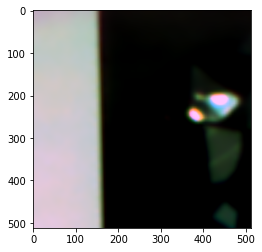

In [45]:
plt.imshow(smpl[...,(160,100,45)])

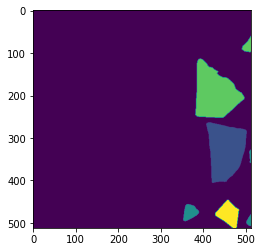

In [46]:
plt.imshow(crops[0][2])

In [7]:
from models.hypernet import HyperNet
model = HyperNet(154,5)
print(model.modules)

<bound method Module.modules of HyperNet(
  (encoder): HyperEncoder(
    (stem): BSA(
      (chattn): SOCA(
        (avg): AdaptiveAvgPool2d(output_size=(20, 20))
        (linear): Linear(in_features=154, out_features=154, bias=True)
      )
      (conv): CBA(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (attn): LSA(
        (cv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (act): Sigmoid()
      )
    )
    (encoder): ModuleList(
      (0): EncodeStage(
        (down): Downsampler(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (compblock): 

In [6]:
import torch
input = torch.randn(20, 154, 416, 416)
out,_ = model(input)

print(out.shape)

torch.Size([20, 5, 416, 416])
